<a href="https://colab.research.google.com/github/ivoytov/manhattan/blob/master/loans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
import numpy as np
import pandas as pd

### Data Sources ###
Loan data is from Bloomberg BVAL, based on end of day price valuation. Loan list is compiled by screening for:

1.   Active Loans
2.   First Lien Rank
3.   Incorporated in the U.S.
4.   Denominated in USD
5.   \>= $1B outstanding
6.   Non-Investment Grade Rating from either S&P *or* Moody's

The screen is run as of the last day of every quarter (3/31, 6/30, 9/30, and 12/31). Loans that mature or expire during a quarter are included in that quarterly period, but are removed from the screen for the following quarter.

### Data Format

* `loan_data` - Loan IDs are arranged as separate columns, with the first column containing the date index. Price is listed as values in XX.XX format (% of par). If price is unavailable, then #N/A is listed. Trading days only. There are two files, one for loans from 12-31-2018 to 10-15-2020 period, and one for the 12-31-2015 to 12-31-2018 period.

* `loan_desc` - Loan IDs are arranged in the first column, with subsequent columns containing metadata on the loan.

* `periods` - Quarters are listed as separate columns. Loan IDs from the above-mentioned screen are listed under the column header with the `as of` date.

In [105]:
# read in historical prices
prices_2019_2020 = pd.read_csv('/content/drive/MyDrive/loans/loan_data_2019-2020.csv', parse_dates=['Dates'], index_col='Dates')
prices_2016_2018 = pd.read_csv('/content/drive/MyDrive/loans/price_data_2016-2018.csv', parse_dates=['Dates'], index_col='Dates')

prices = pd.concat([prices_2016_2018, prices_2019_2020], join="outer", verify_integrity=True)
print("(# dates, # tickers)",prices_2016_2018.shape, prices_2019_2020.shape, prices.shape)
prices = prices.fillna(method="pad")

# not used yet
#desc = pd.read_csv('/content/drive/MyDrive/loans/loan_desc.csv', parse_dates=['FUNDING_DATE', 'MATURITY', ], index_col='ID')

(# dates, # tickers) (749, 946) (463, 530) (1212, 1202)


The trading strategy is to buy every loan that has appreciated by at least 3 points (`BIG_MOVE`) and to short every loan that did the opposite. We exclude loans that are trading at too low prices from the short signals (too much risk of the loan trading up) and vice versa. This is especially relevant on the long side, as we don't want to long loans trading at par or above as there is no upside left.

In [106]:
LOOKBACK_DAYS = 5
HOLD_DAYS = 5
BIG_MOVE = .05
PRICE_RANGE = [85, 85]
price_chg = prices.pct_change(periods=LOOKBACK_DAYS)
sell = (price_chg.shift(1) > BIG_MOVE) & (prices > PRICE_RANGE[0])
buy = (price_chg.shift(1) < -BIG_MOVE) & (prices < PRICE_RANGE[1])
labels = buy*1.0 - sell*1.0

Demonstration of some sample `labels` output. `1` means we are long the loan in the quarter that start on the day shown on the left (index) column. So we are short the loan BL312818 starting 2020-03-31, and we are long the loan BL323453 starging 2020-03-20. `0` means we have no position in the loan, either because it didn't exist or because it didn't have a big move in the lookback period. To avoid lookback bias, the date shown below is one trading day after the loan met the buy or sell criteria.

In [107]:
labels.loc['2020-03-15':'2020-03-31', labels.columns[-6:-3]]

,BL312818,BL323453,BL320288
Dates,,,
2020-03-16,0.0,0.0,0.0
2020-03-17,0.0,0.0,0.0
2020-03-18,0.0,0.0,0.0
2020-03-19,0.0,0.0,0.0
2020-03-20,1.0,1.0,0.0
2020-03-23,1.0,1.0,0.0
2020-03-24,1.0,1.0,0.0
2020-03-25,1.0,1.0,0.0
2020-03-26,0.0,0.0,0.0


Functions to:
* Generate labels between {-1, 0, 1} that mean we are short, neutral, or long the loan ID for that entire period

* Generate bins between {0, 1} that mean that the trade was good (\>$0 PNL, or `1`) or bad (negative PNL, or `0`) based on the side we picked in `labels` and the actual price change in the following period. Ignores interest income.

In [108]:
# triple barrier method function
# close:  a pandas series of prices
# events: a pandas dataframe wiht columns
#   - t1:   the timestamp of vertical barrier. When np.nan, no vertical barrier
#.  - trgt: the unit width of the horizontal barriers
# ptSl: a list of two non negative floats
#   - ptSl[0] the factor that multiplies trgt to set the width of the upper barrier. if 0, no upper barrier
#   - ptSl[1] the factor tha multiplesi trgt ot set the width of the lower barrier. if 0, no lower barrier
# molecule a list with the subset of event indices that will be processed by single thread

def applyPtSlOnT1(close, events, ptSl, molecule):
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_ = events.loc[molecule]
    out = events_[['t1']].copy(deep=True)
    if ptSl[0]>0:
        pt = ptSl[0] * events_['trgt']
    else:
        pt = pd.Series(index=events.index) #NaNs

    if ptSl[1] > 0:
        sl = -ptSl[1] * events_['trgt']
    else:
        sl = pd.Series(index = events.index) #NaNs

    for loc, t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0 = close[loc:t1] #path prices
        df0 = (df0 / close[loc] -1) * events_.at[loc,'side'] # path returns
        out.loc[loc, 'sl'] = df0[df0 < sl[loc]].index.min() # earliest stop loss
        out.loc[loc, 'pt'] = df0[df0 > pt[loc]].index.min() # earliest profit taking
    return out

def getVertBarrier(gRaw, tEvents, numDays: int) -> pd.Series:
    t1 = gRaw.index.searchsorted(tEvents + pd.Timedelta(days = numDays))
    t1 = t1[t1 < gRaw.shape[0]]
    t1 = pd.Series(gRaw.index[t1], index=tEvents[:t1.shape[0]]) #NaNs at the end
    t1 = t1.rename('t1')
    return t1

def getBins(events: pd.DataFrame, close: pd.Series) -> pd.DataFrame:
    '''
    Compute event's outcome (including side info, if provided)
    events is a dataframe where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target return
    -events['side'] (optional) implies the algo's position side
    Case 1: ('side' not in events) bin in (-1, 1) <- label by price action
    Case 2: ('side' in events) bin in (0,1) <- label by pnl (meta labeling)
    '''
    #1) prices aligned with events
    events_ = events.dropna(subset=['t1'])
    px = events_.index.union(events_['t1']).drop_duplicates()
    px = close.reindex(px, method='bfill')

    #2) create out object
    out = pd.DataFrame(index = events_.index)
    out['ret'] = px.loc[events_['t1']].values / px.loc[events_.index] - 1 
    out['t1'] = events_['t1']
    if 'side' in events_:
        out['ret'] *= events_['side']     # meta-labeling

    out['bin'] = np.sign(out['ret'])
    if 'side' in events_:
        out.loc[out['ret'] <= 0, 'bin'] = 0    # meta-labeling
        out['side'] = events_['side']
    return out

# find the time of the first barrier touch
#  close: pandas series of prices
#  tEvents pandas timeindex of timestamps that will seed every ttriple barrier
#  ptSl a non negative flat that sets the width of th two barriers (symm)
# t1 pandas series with the timestamps of the vert barriers. pass false to disable
# trgt: pandas series of targets, expressed in terms of absolute returns
# minRet minimum target return required for running a triple barrier search
# numThreads  not used yet

# output:
# - t1: timestamp of when the first barrier is touched
# - trgt: the target that was used to generate the horizontal barrier

def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads, t1=False, side=None):
    #1) get target
    trgt = trgt.loc[tEvents]
    trgt = trgt[trgt > minRet]

    #2) get t1 (max holding period)
    if t1 is False:
        t1 = pd.Series(pd.NaT, index=tEvents, dtype='datetime64')

    #3) form events object, apply stop loss on t1
    if side is None:
        side_ = pd.Series(1., index=trgt.index)
        ptSl_ = [ptSl, ptSl]
    else:
        side_ = side.loc[trgt.index]
        ptSl_ = ptSl[:2]

    events = pd.concat({'t1': t1, 'trgt': trgt, 'side': side_ }, axis = 1).dropna(subset=['trgt'])

    df0 = applyPtSlOnT1(close, events, ptSl_, events.index)
    events['t1'] = df0.dropna(how='all').apply(lambda x: x.min(),axis=1)
    if side is None:
        events = events.drop('side', axis = 1)
    events = events.dropna(subset=['t1'])
    return events

# daily vol, reindexed to close
def getDailyVol(close, span=14):
    df0 = close.index.searchsorted(close.index - pd.Timedelta(days = 1))
    df0 = df0[df0 > 0]
    df0 = pd.Series(close.index[df0 - 1], index=close.index[close.shape[0] - df0.shape[0]:])
    df0 = close.loc[df0.index] / close.loc[df0].values - 1 # daily returns
    df0 = df0.ewm(span=span).std().rename('trgt')
    return df0

def getBins(events, close):
    '''
    Compute event's outcome (including side info, if provided)
    events is a dataframe where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target return
    -events['side'] (optional) implies the algo's position side
    Case 1: ('side' not in events) bin in (-1, 1) <- label by price action
    Case 2: ('side' in events) bin in (0,1) <- label by pnl (meta labeling)
    '''
    #1) prices aligned with events
    events_ = events.dropna(subset=['t1'])
    px = events_.index.union(events_['t1']).drop_duplicates()
    px = close.reindex(px, method='bfill')

    #2) create out object
    out = pd.DataFrame(index = events_.index)
    out['ret'] = px.loc[events_['t1']].values / px.loc[events_.index] - 1 
    out['t1'] = events_['t1']
    if 'side' in events_:
        out['ret'] *= events_['side']     # meta-labeling

    out['bin'] = np.sign(out['ret'])
    if 'side' in events_:
        out.loc[out['ret'] <= 0, 'bin'] = 0    # meta-labeling
        out['side'] = events_['side']
    return out

The trading strategy is to observer trading prices of loans trading below 85 (`PRICE_RANGE`), when one of them gains 3 percent (`BIG_MOVE`) in any 5 day period (`LOOKBACK_DAYS`), then we buy the loan on the following days close. We hold the loan for 5 days (`HOLD_DAYS`) and sell. If the position moves in our favor or against us by 3%, then we stop loss or harvest early.

The `getBins` function returns a table of trade outcomes for each loan in {0,1} - 1 if trade made money, 0 if the trade lost money. 

In [109]:
out = pd.DataFrame()
for ticker in labels.columns:
  dates = labels[ticker][labels[ticker] != 0].index
  t1 = getVertBarrier(prices[ticker], dates, HOLD_DAYS)
  trgt = getDailyVol(prices[ticker])
  events = getEvents(prices[ticker], dates, ptSl=[.03,.03], trgt=trgt, minRet=0.01, numThreads=1, t1=t1, side=labels[ticker])
  bins = getBins(events, prices[ticker])
  bins['ticker'] = ticker   
  out = pd.concat([out, bins])

bins = out.set_index('ticker', append=True)
bins

,,ret,t1,bin,side
Dates,ticker,,,,
2016-12-21,BL101755,0.021684,2016-12-22,1.0,-1.0
2016-12-22,BL101755,-0.014999,2016-12-23,0.0,-1.0
2016-06-21,BL787561,0.039761,2016-06-22,1.0,1.0
2016-06-22,BL787561,0.015296,2016-06-23,1.0,1.0
2016-06-23,BL787561,-0.003766,2016-06-24,0.0,1.0
...,...,...,...,...,...
2020-04-13,BL320288,-0.002334,2020-04-20,0.0,-1.0
2020-04-14,BL320288,-0.002470,2020-04-20,0.0,-1.0
2020-04-15,BL320288,-0.002586,2020-04-20,0.0,-1.0


Group the events by side and calculate how often the trade makes money. Both events triggered thousands of times so this is a robust sample - but do note that there is some overlap in the events. There were more long than short events. The long trades generated a median return of 4 bps in the reasonably short holding period, while the short trades lost 2 bps. This is before trading fees, which on a $1B+ loan can be estimated at ~30 bps each side (60bps round trip).

In [110]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

pd.pivot_table(bins, index=['side'], values='ret', aggfunc=[len, np.mean,  percentile(25), 
                                                            percentile(50), percentile(75), 
                                                            max, min, np.sum])

,len,mean,percentile_25,percentile_50,percentile_75,max,min,sum
,ret,ret,ret,ret,ret,ret,ret,ret
side,,,,,,,,
-1.0,1998.0,-0.002880,-0.007551,-0.001952,0.002062,0.237430,-0.108274,-5.753618
1.0,2896.0,0.001714,-0.010024,0.000433,0.012274,0.652025,-0.488593,4.964335


Plot the histogram of the returns from the long trades and then the short trades. We clip the histogram window at +/- 10% return to avoid showing the huge outliers.

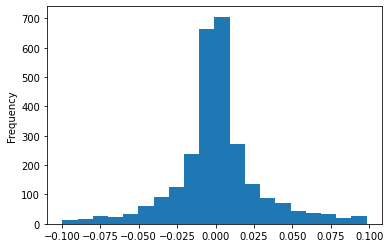

In [112]:
bins[(bins.side == 1) & (bins.ret <.1) & (bins.ret >-.1)].ret.plot.hist(bins=20)

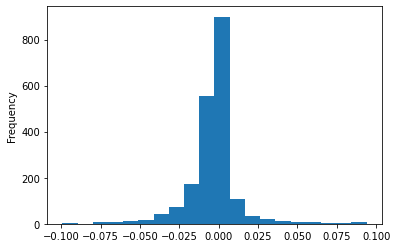

In [113]:
bins[(bins.side == -1) & (bins.ret <.1) & (bins.ret >-.1)].ret.plot.hist(bins=20)